### Import modules and verify they work? 

In [9]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# general eWC
import ewatercycle
import ewatercycle.models

In [11]:
# pip install ewatercycle-HBV==1.1.2

In [12]:
# pip install HBV

In [13]:
# for local mode
from typing import Type
from ewatercycle.base.model import LocalModel
from ewatercycle_HBV.model import HBVMethods # Use custom forcing instead
from HBV import HBV as HBV_bmi
from bmipy import Bmi

class LocalModelHBV(LocalModel, HBVMethods):
    """The HBV eWaterCycle model, with the local BMI."""
    bmi_class: Type[Bmi] = HBV_bmi

#### set up paths

In [14]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [15]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [16]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

In [17]:
from ewatercycle_HBV.forcing import HBVForcing

In [18]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
HRU_id = 2479155
alpha = 1.2626

In [19]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          forcing_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha= alpha
                          )

In [20]:
ds = test_forcing.from_camels_txt()

#### Can also run locally when developing - v0.1.1. here
```py
from ewatercycle.container import ContainerImage
LeakyBucket(forcing=forcing, bmi_image=ContainerImage("local_image:latest"))
```

In [13]:
from ewatercycle.container import ContainerImage
local_model = LocalModelHBV(forcing=test_forcing)

need to  add a local container to run

In [14]:
config_file, _ = local_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [15]:
local_model.initialize(config_file)

In [16]:
Q_m = []
time = []
while local_model.time < local_model.end_time:
    local_model.update()
    Q_m.append(local_model.get_value("Q_m"))
    time.append(local_model.time_as_datetime.date())

local_model.finalize()

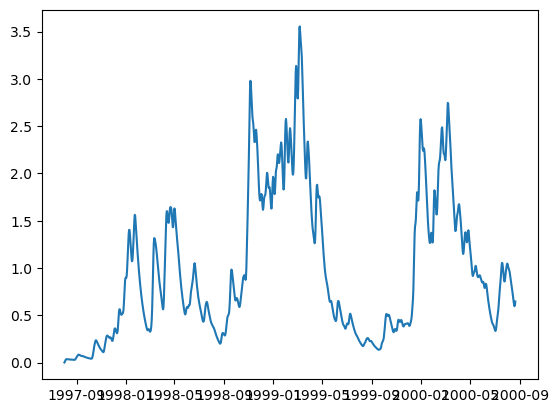

In [17]:
plt.plot(time[:-10], Q_m[:-10])

#### testing with setting/getting values HBV-bmi v1.1.1/docker 1.9

In [18]:
local_model = LocalModelHBV(forcing=test_forcing)
config_file, _ = local_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )
local_model.initialize(config_file)

In [19]:
local_model.update()

In [20]:
local_model.get_value("Q_m")

array([0.00200467])

In [21]:
local_model.update()

In [22]:
local_model.get_value("Q_m")

array([0.00802432])

In [23]:
local_model.get_value("Tlag")[0]

6.0

In [24]:
for i in range(int(local_model.get_value("Tlag")[0])):
    print(i)

0
1
2
3
4
5


In [25]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.01605427, 0.02007488, 0.01606553, 0.00803558, 0.0020103 ,
       0.        ])

In [26]:
old_T_lag = 5

In [27]:
# local_model.set_value("Tlag",np.array([10]))

In [28]:
local_model.get_value("memory_vector1")

array([0.02007488])

In [29]:
new_T_lag = 6

In [30]:
# np.zeros(new_T_lag)+ old_memory_vector 

In [31]:
local_model.update()

In [32]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.02641495, 0.02663233, 0.01860238, 0.00835038, 0.00211336,
       0.        ])

In [33]:
new_memory_vector = np.zeros(new_T_lag)
new_memory_vector

array([0., 0., 0., 0., 0., 0.])

In [34]:
# new_memory_vector[:old_T_lag] = old_memory_vector

In [35]:
new_memory_vector

array([0., 0., 0., 0., 0., 0.])

In [36]:
local_model.update()

In [37]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03286729, 0.02899398, 0.01874199, 0.00834832, 0.00207832,
       0.        ])

In [38]:
new_T_lag = 3

In [39]:
new_memory_vector = np.zeros(new_T_lag)
new_memory_vector

array([0., 0., 0.])

In [40]:
if old_T_lag < new_T_lag:
    new_memory_vector[:old_T_lag] = old_memory_vector
elif old_T_lag > new_T_lag:
    new_memory_vector = old_memory_vector[:new_T_lag]
    new_memory_vector[-1] += sum(old_memory_vector[new_T_lag:])
    

In [41]:
new_memory_vector

array([0.03286729, 0.02899398, 0.02916863])

In [42]:
local_model.update()

In [43]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03512946, 0.02896779, 0.01857412, 0.0082138 , 0.00204516,
       0.        ])

In [44]:
local_model.set_value("Tlag",np.array([4]))

In [45]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03512946, 0.02896779, 0.01857412, 0.01025896])

In [46]:
local_model.set_value("Tlag",np.array([5]))

In [47]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03512946, 0.02896779, 0.01857412, 0.01025896, 0.        ])

In [48]:
local_model.finalize()

### test docker v0.1.9 - works nicely

In [13]:
from ewatercycle_HBV.model import HBV
model = HBV(forcing=test_forcing)

In [14]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )
model.initialize(config_file)

In [15]:
model.update()

In [57]:
old_memory_vector = np.array([model.get_value(f"memory_vector{i}") for i in range(int(model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.00601401, 0.01002336, 0.01002336, 0.00601401, 0.00200467,
       0.        ])

In [59]:
model.set_value("Tlag",np.array([3]))

In [60]:
new_memory_vector = np.array([model.get_value(f"memory_vector{i}") for i in range(int(model.get_value("Tlag")[0]))]).flatten()
new_memory_vector

array([0.00601401, 0.01002336, 0.01804204])

In [61]:
model.update()

In [62]:
old_memory_vector = np.array([model.get_value(f"memory_vector{i}") for i in range(int(model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.0301264 , 0.02608326, 0.        ])

In [63]:
model.set_value("Tlag",np.array([0.9221]))

In [64]:
new_memory_vector = np.array([model.get_value(f"memory_vector{i}") for i in range(int(model.get_value("Tlag")[0]))]).flatten()
new_memory_vector

array([0.05620965])

In [65]:
model.update()

In [16]:
model.finalize()

## load Q

In [23]:
observations = observations_path / f'0{HRU_id}_streamflow_qc.txt'

In [24]:
cubic_ft_to_cubic_m = 0.0283168466 

In [25]:
new_header = ['GAGEID','Year','Month', 'Day', 'Streamflow(cubic feet per second)','QC_flag']
new_header_dict = dict(list(zip(range(len(new_header)),new_header)))

df_Q = pd.read_fwf(observations,delimiter=' ',encoding='utf-8',header=None)
df_Q = df_Q.rename(columns=new_header_dict)
df_Q['Streamflow(cubic feet per second)'] = df_Q['Streamflow(cubic feet per second)'].apply(lambda x: np.nan if x==-999.00 else x)
df_Q['Q (m3/s)'] = df_Q['Streamflow(cubic feet per second)'] * cubic_ft_to_cubic_m
df_Q['Q'] = df_Q['Q (m3/s)'] / ds.attrs['area basin(m^2)'] * 3600 * 24 * 1000 # m3/s -> m/s ->m/d -> mm/d
df_Q.index = df_Q.apply(lambda x: pd.Timestamp(f'{int(x.Year)}-{int(x.Month)}-{int(x.Day)}'),axis=1)
df_Q.index.name = "time"
df_Q.drop(columns=['Year','Month', 'Day','Streamflow(cubic feet per second)'],inplace=True)
df_Q = df_Q.dropna(axis=0)

,GAGEID,QC_flag,Q (m3/s),Q
time,,,,
1997-08-01,2479155,A,1.755644,1.113916
1997-08-02,2479155,A,1.076040,0.682723
1997-08-03,2479155,A,0.679604,0.431193
1997-08-04,2479155,A,0.538020,0.341361
1997-08-05,2479155,A,0.481386,0.305429
...,...,...,...,...
2000-08-27,2479155,A,0.101941,0.064679
2000-08-28,2479155,A,0.099109,0.062882
2000-08-29,2479155,A,0.093446,0.059289


Text(0, 0.5, 'Volume in mm/d')

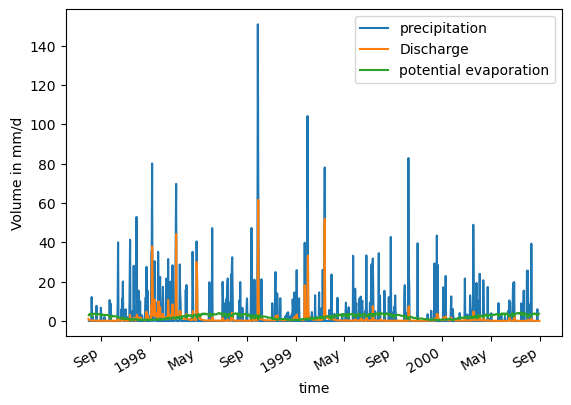

In [55]:
fig, ax = plt.subplots(1,1)
ds['pr'].plot(ax=ax,label="precipitation")
df_Q.loc[list(pd.date_range(experiment_start_date[:-1],experiment_end_date[:-1]))]['Q'].plot(ax=ax,label="Discharge")
ds['pev'].plot(ax=ax,label="potential evaporation")
ax.legend()
ax.set_ylabel("Volume in mm/d")
